In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.append("..")
sys.path.append("../src")
sys.path.append("../utils")
sys.path.append("../phantoms")
sys.path.append("../projections")
from src.algs import *
from src.projections import *
from src.phantoms import *


In [37]:
# measurement parameters
n_projections = 50
n_detectors = 512
det_spacing = 1
noise_factor = None
angles = np.linspace(0, np.pi*(180/180), n_projections)
# dart paramenters
dart_iters = 50
p = 0.9
rec_alg = 'SART_CUDA'
rec_iters = 1000
# compared algs iters
comp_iters = dart_iters * rec_iters

# open phantom
img = np.array(Image.open('../phantoms/paws/paw_1.png'))
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
img_width, img_height = img.shape

# prepare all the data
img = np.array(Image.fromarray(img), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
# make measurements
projector_id, sino_id, sinogram = project_from_2D(phantom_id=phantom_id,
                                                vol_geom=vol_geom,
                                                n_projections=n_projections,
                                                n_detectors=n_detectors,
                                                detector_spacing=det_spacing,
                                                angles=angles,
                                                noise_factor=noise_factor,
                                                use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing, 
                                        n_detectors, angles)

# instanciate DART
dart = DART(gray_levels=gray_lvls, p=p, rec_shape=img.shape,
        proj_geom=proj_geom, projector_id=projector_id,
        sinogram=sinogram)

Mean absolute pixel error: 0.6210745573043823


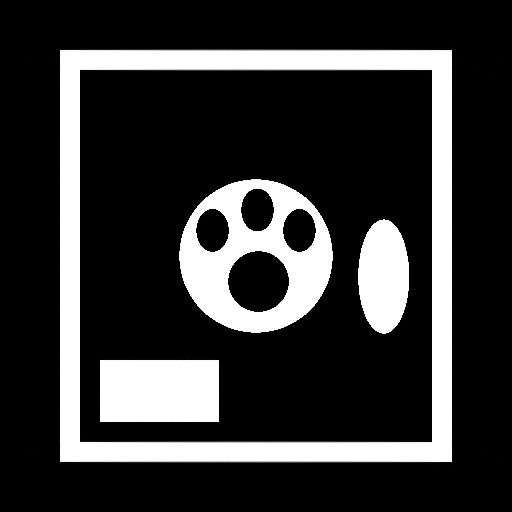

In [38]:
# run the algorithm
full_rec = dart.run(iters=dart_iters, rec_alg=rec_alg, rec_iter=rec_iters)
print(f"Mean absolute pixel error: {np.abs(img - full_rec).mean()}")
Image.fromarray(full_rec.astype(np.uint8))